# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.20 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.17649999605491756


When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [6]:
import models
actor = models.ActorModel(state_size, action_size)
critic = models.CriticModel(state_size, action_size)

In [7]:
actor

ActorModel(
  (fc1): Linear(in_features=33, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=4, bias=True)
)

In [8]:
critic

CriticModel(
  (fc1): Linear(in_features=33, out_features=400, bias=True)
  (fc2): Linear(in_features=404, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)

In [9]:
target_score = 30.0
target_episodes = 100

## Define the training function
def train_agent(env, agent, n_episodes=1000, max_t=1000):
    """Deep Deterministic Policy Gradients (DDPG).
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    scores = []      # episodic scores
    avg = []
    moving_avg_window = deque(maxlen=target_episodes)  # moving average over 100 episodes and over all agents
    
    ## Perform n_episodes of training
    for i_episode in range(1, n_episodes+1):
        agent.reset()
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations 
        scores_episode = np.zeros(num_agents)           # rewards per episode for each agent

        for t in range(1, max_t+1):
            # Perform a step: S;A;R;S'
            actions = agent.act(states)                 # select the next action for each agent
            env_info = env.step(actions)[brain_name]    # send the actions to the environment
            rewards = env_info.rewards                  # get the rewards
            next_states = env_info.vector_observations  # get the next states
            dones = env_info.local_done
            
            # Send the results to the Agent         
            agent.step(t, states, actions, rewards, next_states, dones)   
            # Update the variables for the next iteration
            states = next_states
            scores_episode += rewards
            
            if np.any(dones):
                break

        # Store the rewards and calculate the moving average
        score_episode_mean = scores_episode.mean()
        moving_avg_window.append(np.mean(scores_episode))
        scores.append(score_episode_mean)
               

        ## Print the results for this episode
        print('Episode {:3d}\tScore: {:5.2f} \t' \
              'Moving average: {:5.2f}' \
              .format(i_episode, score_episode_mean,
                      np.mean(moving_avg_window)))

        ## Check if the environment has been solved
        mean_score = np.mean(moving_avg_window)
        avg.append(mean_score)
        if mean_score >= target_score and i_episode >= target_episodes:
            print('\nEnvironment solved in {:d} episodes!\t' \
                  'Average Score: {:.2f}'
                  .format(i_episode-target_episodes, mean_score))
            
            ## Save the model along with some training information
            checkpoint = {
                'actor_dict': agent.actor.state_dict(),
                'critic_dict': agent.critic.state_dict(),               
                'episodes': i_episode,
                'scores': scores,
                'moving_avg': avg,
                }
            print('\nSaving model ...', end=' ')
            torch.save(checkpoint, 'checkpoint.pt')
            print('done.')

            break

    return scores, avg

In [10]:
import ddpgagent
agent = ddpgagent.DDPGAgent(state_size, action_size, num_agents, seed=5)
scores, avg = train_agent(env, agent)

Episode   1	Score:  1.00 	Moving average:  1.00
Episode   2	Score:  1.14 	Moving average:  1.07
Episode   3	Score:  1.59 	Moving average:  1.25
Episode   4	Score:  2.78 	Moving average:  1.63
Episode   5	Score:  3.97 	Moving average:  2.10
Episode   6	Score:  5.15 	Moving average:  2.61
Episode   7	Score:  6.40 	Moving average:  3.15
Episode   8	Score:  8.07 	Moving average:  3.76
Episode   9	Score: 10.06 	Moving average:  4.46
Episode  10	Score: 12.06 	Moving average:  5.22
Episode  11	Score: 15.30 	Moving average:  6.14
Episode  12	Score: 19.98 	Moving average:  7.29
Episode  13	Score: 25.58 	Moving average:  8.70
Episode  14	Score: 30.32 	Moving average: 10.24
Episode  15	Score: 31.61 	Moving average: 11.67
Episode  16	Score: 32.97 	Moving average: 13.00
Episode  17	Score: 34.43 	Moving average: 14.26
Episode  18	Score: 36.44 	Moving average: 15.49
Episode  19	Score: 37.56 	Moving average: 16.65
Episode  20	Score: 37.99 	Moving average: 17.72
Episode  21	Score: 37.04 	Moving average

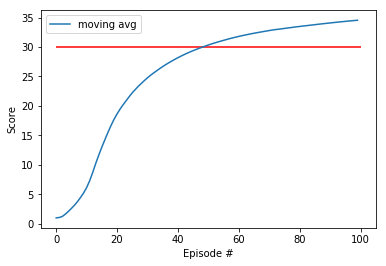

In [19]:
import matplotlib.pyplot as plt
plt.figure()
plt.hlines(target_score, 0 , len(avg), colors='r')
plt.plot(np.arange(len(avg)), avg, label='moving avg')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

In [11]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states, train=False)      # select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 38.784999133087695


In [20]:
env.close()